(0.0, 64.99933333333334)

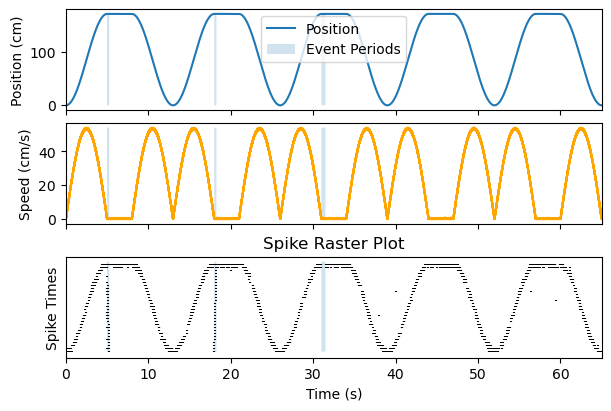

In [17]:
from non_local_detector.simulate.sorted_spikes_simulation import make_simulated_data
import numpy as np
import matplotlib.pyplot as plt

(
    speed,
    position,
    spike_times,
    time,
    event_times,
    sampling_frequency,
    is_event,
    place_fields,
) = make_simulated_data(n_neurons=30)

fig, axes = plt.subplots(3, 1, figsize=(6, 4), sharex=True, constrained_layout=True)
axes[0].plot(time, position, label='Position')
axes[0].set_ylabel('Position (cm)')
axes[0].fill_between(
    time,
    is_event * np.max(position),
    alpha=0.2,
    label='Event Periods'
)
axes[0].legend()

axes[1].plot(time, speed, label='Speed', color='orange')
axes[1].set_ylabel('Speed (cm/s)')
axes[1].fill_between(
    time, is_event * np.max(speed), alpha=0.2, label="Event Periods"
)

axes[2].eventplot(spike_times, lineoffsets=1, linelengths=0.5, color='black')
axes[2].set_ylabel('Spike Times')
axes[2].set_xlabel('Time (s)')
axes[2].set_yticks([])
axes[2].set_title('Spike Raster Plot')
axes[2].fill_between(
    time, is_event * len(spike_times), alpha=0.2, label="Event Periods"
)
axes[2].set_xlim(0, time[-1])

In [2]:
# from non_local_detector.environment import Environment

# env = Environment(name="")
# env._is_fitted

In [18]:
from non_local_detector import NonLocalSortedSpikesDetector

detector = NonLocalSortedSpikesDetector(
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": 6.0,
        "block_size": int(2**12),
    },
).fit(time, position, spike_times, is_training=~is_event)

Encoding models:   0%|          | 0/30 [00:00<?, ?cell/s]

In [19]:
results = detector.predict(
    spike_times=spike_times,
    time=time,
    position=position,
    position_time=time,
    save_log_likelihood_to_results=True,
)

Local Likelihood:   0%|          | 0/30 [00:00<?, ?cell/s]

No Spike Likelihood:   0%|          | 0/30 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/30 [00:00<?, ?cell/s]

/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/models/base.py:1222: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'state_bins' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  results = xr.Dataset(


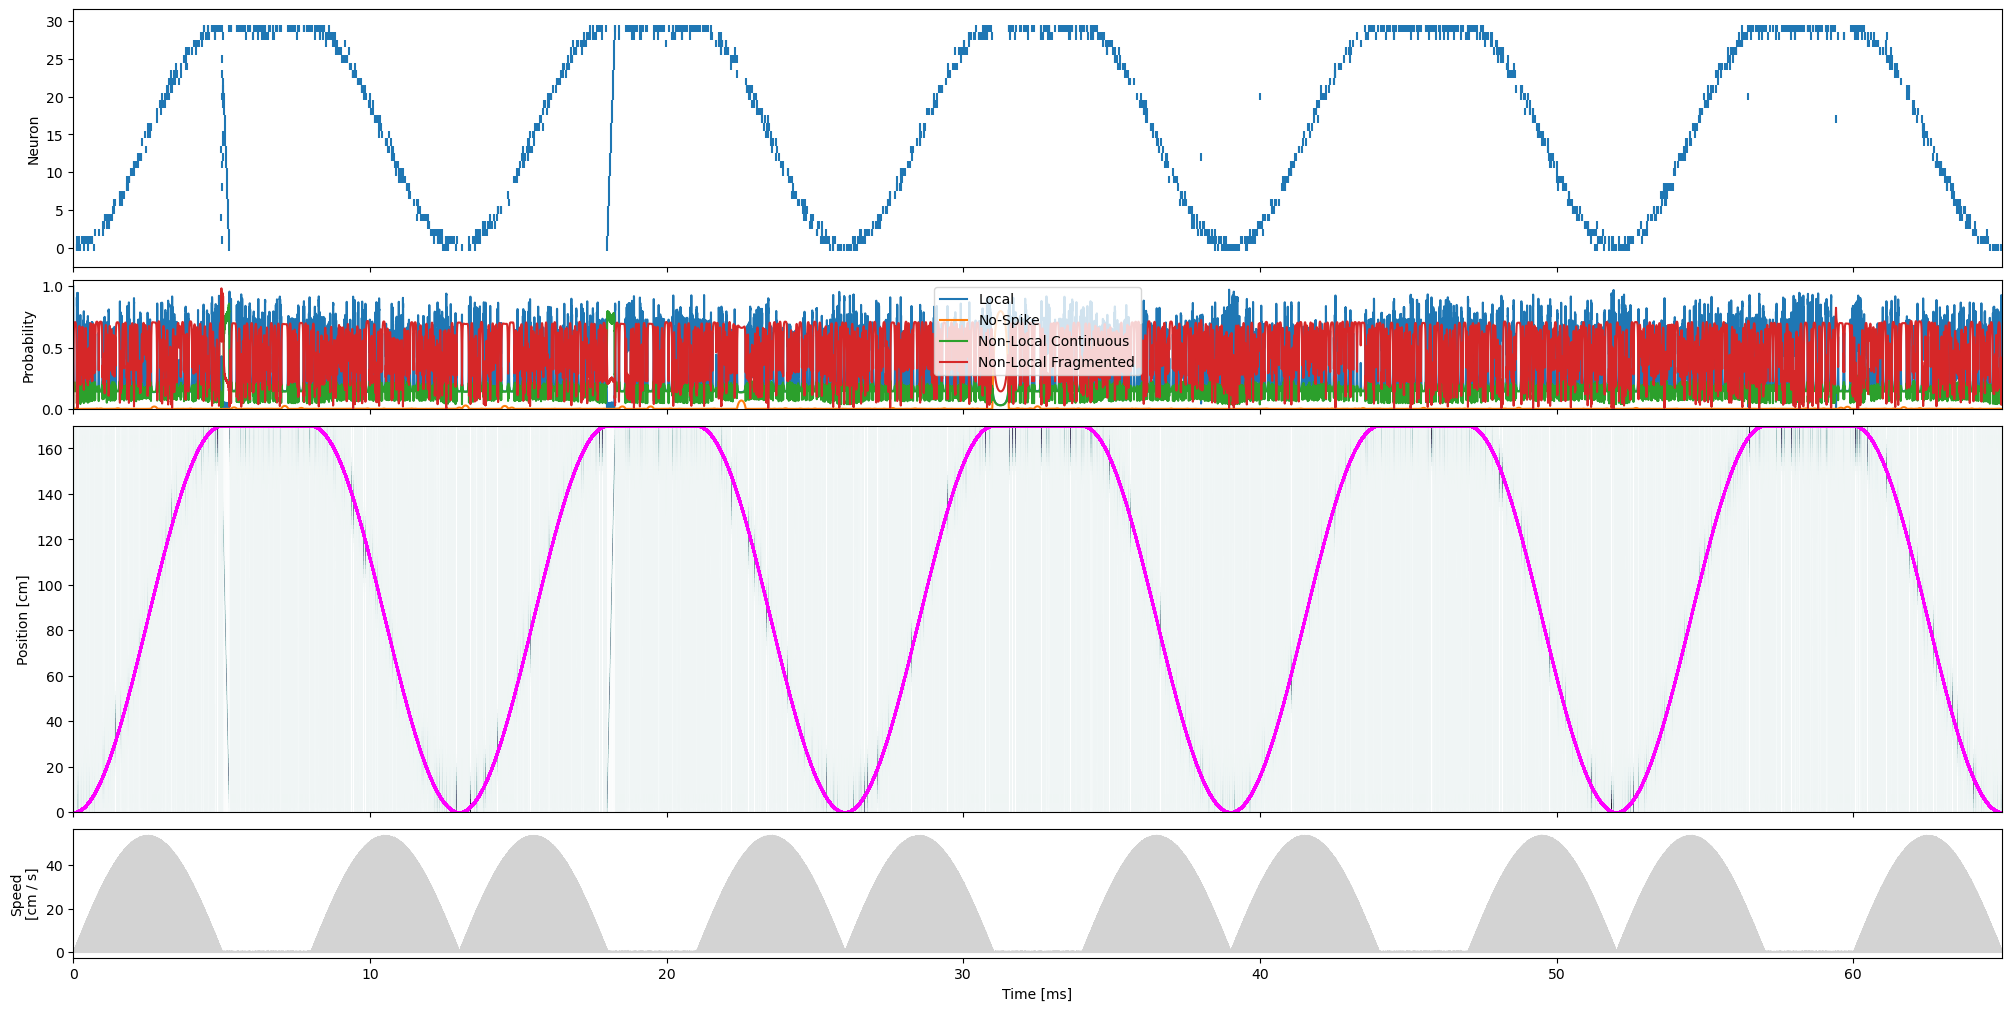

In [20]:
from non_local_detector.visualization import plot_non_local_model

plot_non_local_model(
    time,
    position,
    spike_times,
    speed,
    detector,
    results,
    figsize=(20, 10),
)

/var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/ipykernel_79067/3774206887.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[3].legend().set_visible(False)


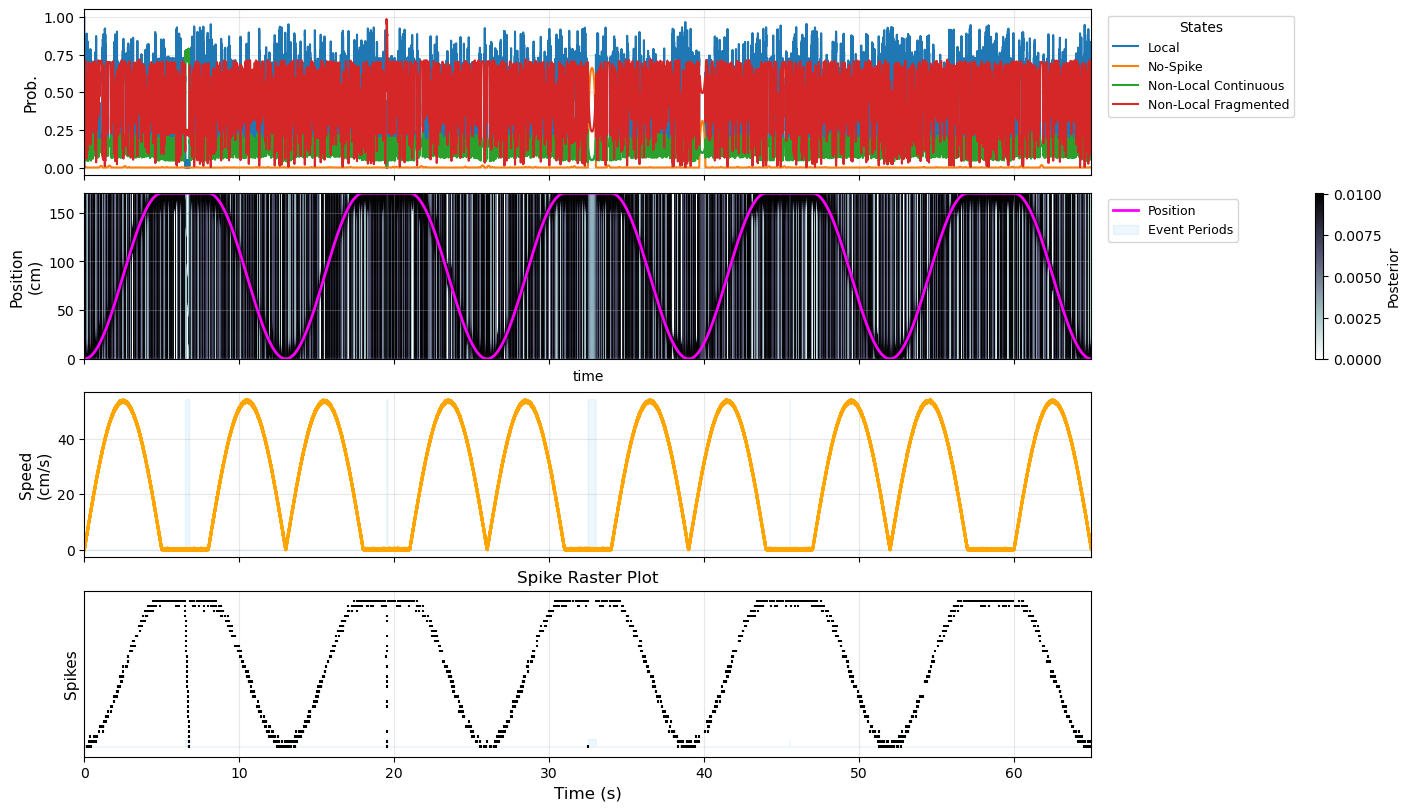

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharex=True, constrained_layout=True)

# --- Panel 1: State Probabilities ---
state_colors = ["C0", "C1", "C2", "C3"]  # Or choose a palette you like
for i, state in enumerate(results.acausal_state_probabilities.states.values):
    axes[0].plot(
        results.acausal_state_probabilities.time,
        results.acausal_state_probabilities.sel(states=state),
        label=str(state),
        linewidth=1.5,
        color=state_colors[i % len(state_colors)],
    )
axes[0].set_ylabel("Prob.", fontsize=11)
axes[0].legend(loc="upper left", bbox_to_anchor=(1.01, 1), fontsize=9, title="States")
axes[0].grid(True, alpha=0.3)

# --- Panel 2: Position and Posterior Heatmap ---

posterior = (
    results.acausal_posterior.unstack("state_bins")
    .sel(state=["Non-Local Continuous", "Non-Local Fragmented"])
    .sum("state")
)

im = posterior.plot(
    ax=axes[1],
    x="time",
    y="position",
    rasterized=True,
    vmin=0.0,
    robust=True,
    cmap="bone_r",
    add_colorbar=False,
)
axes[1].plot(time, position, label="Position", color="magenta", linewidth=2)
axes[1].fill_between(
    time,
    is_event * np.max(position),
    alpha=0.15,
    color="skyblue",
    label="Event Periods",
)
axes[1].set_ylabel("Position\n(cm)", fontsize=11)
axes[1].legend(loc="upper left", bbox_to_anchor=(1.01, 1), fontsize=9)
axes[1].grid(True, alpha=0.3)
# Optional colorbar
cbar = fig.colorbar(im, ax=axes[1], pad=0.02)
cbar.set_label("Posterior", fontsize=10)

# --- Panel 3: Speed ---
axes[2].plot(time, speed, label="Speed", color="orange", linewidth=2)
axes[2].fill_between(time, is_event * np.max(speed), alpha=0.15, color="skyblue")
axes[2].set_ylabel("Speed\n(cm/s)", fontsize=11)
axes[2].grid(True, alpha=0.3)
# Only add Event Periods to first two legends for clarity

# --- Panel 4: Spike Raster ---
axes[3].eventplot(spike_times, lineoffsets=1, linelengths=0.5, color="black")
axes[3].fill_between(
    time, is_event * 1.5, alpha=0.15, color="skyblue"
)  # Adjust height to fit plot
axes[3].set_ylabel("Spikes", fontsize=11)
axes[3].set_xlabel("Time (s)", fontsize=12)
axes[3].set_yticks([])
axes[3].set_title("Spike Raster Plot", fontsize=12)
axes[3].set_xlim(0, time[-1])
axes[3].grid(True, alpha=0.3)

# Remove repetitive legends
axes[2].legend().set_visible(False)
axes[3].legend().set_visible(False)

plt.show()

In [6]:
# for field in detector.encoding_model_[("", 0)]["place_fields"]:
#     plt.plot(
#         detector.environments[0].bin_centers,
#         field,
#     )

In [7]:
from non_local_detector.models import ContFragSortedSpikesClassifier

classifier = ContFragSortedSpikesClassifier(
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": 6.0,
        "block_size": int(2**12),
    },
).fit(
    position_time=time,
    position=position,
    spike_times=spike_times,
    is_training=~is_event,
)
results2 = classifier.predict(
    spike_times=spike_times,
    time=time,
)

Encoding models:   0%|          | 0/30 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/30 [00:00<?, ?cell/s]

/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/models/base.py:1222: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'state_bins' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  results = xr.Dataset(


/var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/ipykernel_79067/3533981078.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[3].legend().set_visible(False)


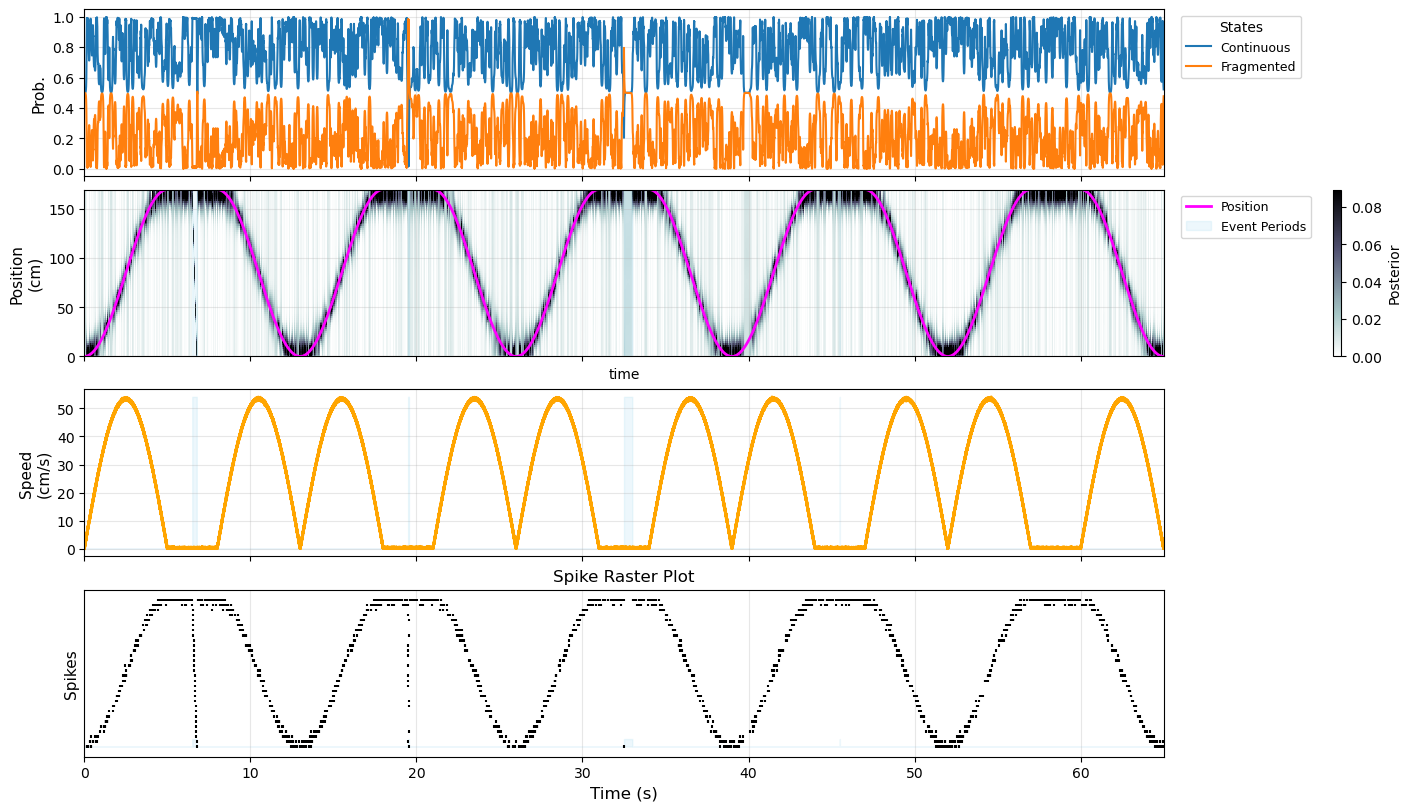

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharex=True, constrained_layout=True)

# --- Panel 1: State Probabilities ---
state_colors = ["C0", "C1", "C2", "C3"]  # Or choose a palette you like
for i, state in enumerate(results2.acausal_state_probabilities.states.values):
    axes[0].plot(
        results2.acausal_state_probabilities.time,
        results2.acausal_state_probabilities.sel(states=state),
        label=str(state),
        linewidth=1.5,
        color=state_colors[i % len(state_colors)],
    )
axes[0].set_ylabel("Prob.", fontsize=11)
axes[0].legend(loc="upper left", bbox_to_anchor=(1.01, 1), fontsize=9, title="States")
axes[0].grid(True, alpha=0.3)

# --- Panel 2: Position and Posterior Heatmap ---

posterior = (
    results2.acausal_posterior.unstack("state_bins")
    .sel(state=["Continuous", "Fragmented"])
    .sum("state")
)

im = posterior.plot(
    ax=axes[1],
    x="time",
    y="position",
    rasterized=True,
    vmin=0.0,
    robust=True,
    cmap="bone_r",
    add_colorbar=False,
)
axes[1].plot(time, position, label="Position", color="magenta", linewidth=2)
axes[1].fill_between(
    time,
    is_event * np.max(position),
    alpha=0.15,
    color="skyblue",
    label="Event Periods",
)
axes[1].set_ylabel("Position\n(cm)", fontsize=11)
axes[1].legend(loc="upper left", bbox_to_anchor=(1.01, 1), fontsize=9)
axes[1].grid(True, alpha=0.3)
# Optional colorbar
cbar = fig.colorbar(im, ax=axes[1], pad=0.02)
cbar.set_label("Posterior", fontsize=10)

# --- Panel 3: Speed ---
axes[2].plot(time, speed, label="Speed", color="orange", linewidth=2)
axes[2].fill_between(time, is_event * np.max(speed), alpha=0.15, color="skyblue")
axes[2].set_ylabel("Speed\n(cm/s)", fontsize=11)
axes[2].grid(True, alpha=0.3)
# Only add Event Periods to first two legends for clarity

# --- Panel 4: Spike Raster ---
axes[3].eventplot(spike_times, lineoffsets=1, linelengths=0.5, color="black")
axes[3].fill_between(
    time, is_event * 1.5, alpha=0.15, color="skyblue"
)  # Adjust height to fit plot
axes[3].set_ylabel("Spikes", fontsize=11)
axes[3].set_xlabel("Time (s)", fontsize=12)
axes[3].set_yticks([])
axes[3].set_title("Spike Raster Plot", fontsize=12)
axes[3].set_xlim(0, time[-1])
axes[3].grid(True, alpha=0.3)

# Remove repetitive legends
axes[2].legend().set_visible(False)
axes[3].legend().set_visible(False)

plt.show()

In [9]:
classifier.continuous_state_transitions_.sum(axis=1)

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2.])

In [10]:
classifier.initial_conditions_.sum()  # Check initial conditions

np.float64(0.9999999962747097)

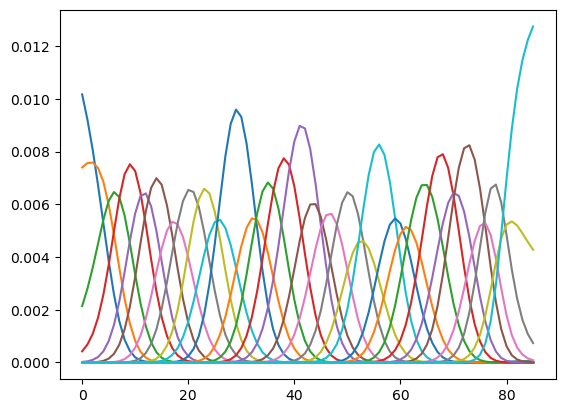

In [11]:
plt.plot(classifier.encoding_model_[("", 0)]["place_fields"].T)

In [12]:
from non_local_detector.models import SortedSpikesDecoder

decoder = SortedSpikesDecoder(
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": 6.0,
        "block_size": int(2**12),
    },
).fit(
    position_time=time,
    position=position,
    spike_times=spike_times,
    is_training=~is_event,
)

Encoding models:   0%|          | 0/30 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/30 [00:00<?, ?cell/s]

/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/models/base.py:1222: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'state_bins' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  results = xr.Dataset(
/var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/ipykernel_79067/4039719676.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(loc="upper left"

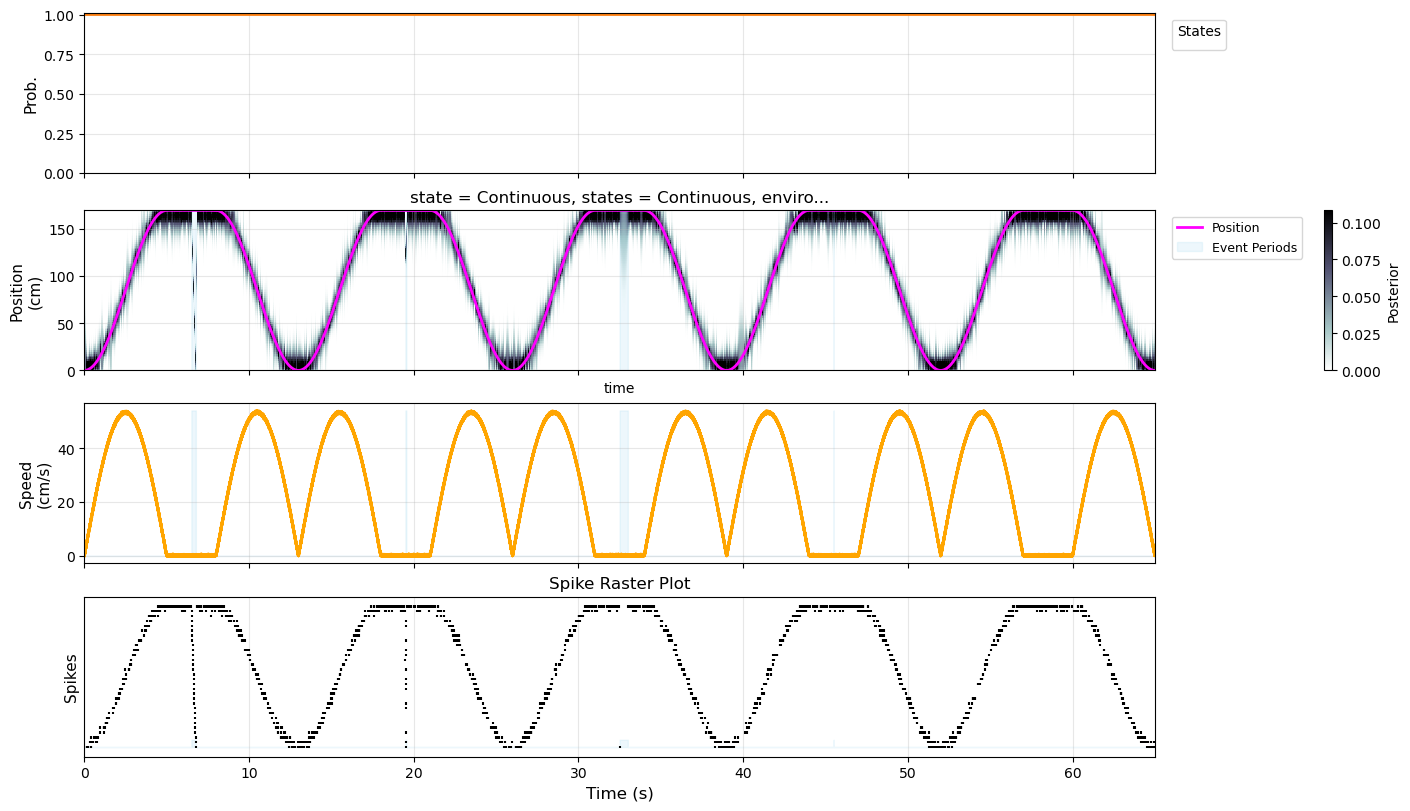

In [13]:
results3 = decoder.predict(
    spike_times=spike_times,
    time=time,
    position=position,
    position_time=time,
    save_log_likelihood_to_results=True,
)

fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharex=True, constrained_layout=True)

# --- Panel 1: State Probabilities ---
axes[0].plot(
    results3.acausal_state_probabilities.time,
    results3.acausal_state_probabilities,
    linewidth=1.5,
    color="C1",
)
axes[0].set_ylabel("Prob.", fontsize=11)
axes[0].legend(loc="upper left", bbox_to_anchor=(1.01, 1), fontsize=9, title="States")
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim((0, 1.01))

# --- Panel 2: Position and Posterior Heatmap ---

posterior = (
    results3.acausal_posterior.unstack("state_bins")
)

im = posterior.plot(
    ax=axes[1],
    x="time",
    y="position",
    rasterized=True,
    vmin=0.0,
    robust=True,
    cmap="bone_r",
    add_colorbar=False,
)
axes[1].plot(time, position, label="Position", color="magenta", linewidth=2)
axes[1].fill_between(
    time,
    is_event * np.max(position),
    alpha=0.15,
    color="skyblue",
    label="Event Periods",
)
axes[1].set_ylabel("Position\n(cm)", fontsize=11)
axes[1].legend(loc="upper left", bbox_to_anchor=(1.01, 1), fontsize=9)
axes[1].grid(True, alpha=0.3)
# Optional colorbar
cbar = fig.colorbar(im, ax=axes[1], pad=0.02)
cbar.set_label("Posterior", fontsize=10)

# --- Panel 3: Speed ---
axes[2].plot(time, speed, label="Speed", color="orange", linewidth=2)
axes[2].fill_between(time, is_event * np.max(speed), alpha=0.15, color="skyblue")
axes[2].set_ylabel("Speed\n(cm/s)", fontsize=11)
axes[2].grid(True, alpha=0.3)
# Only add Event Periods to first two legends for clarity

# --- Panel 4: Spike Raster ---
axes[3].eventplot(spike_times, lineoffsets=1, linelengths=0.5, color="black")
axes[3].fill_between(
    time, is_event * 1.5, alpha=0.15, color="skyblue"
)  # Adjust height to fit plot
axes[3].set_ylabel("Spikes", fontsize=11)
axes[3].set_xlabel("Time (s)", fontsize=12)
axes[3].set_yticks([])
axes[3].set_title("Spike Raster Plot", fontsize=12)
axes[3].set_xlim(0, time[-1])
axes[3].grid(True, alpha=0.3)

# Remove repetitive legends
axes[2].legend().set_visible(False)
axes[3].legend().set_visible(False)

plt.show()

In [14]:
results3.acausal_state_probabilities

<xarray.DataArray 'acausal_state_probabilities' (time: 97500)> Size: 390kB
array([1.0000001, 1.0000001, 1.       , ..., 1.       , 1.       ,
       0.9999999], dtype=float32)
Coordinates:
  * time             (time) float64 780kB 0.0 0.0006667 0.001333 ... 65.0 65.0
    states           <U10 40B 'Continuous'
    environments     <U1 4B ''
    encoding_groups  int64 8B 0

In [15]:
log_likelihood = decoder.compute_log_likelihood(
    time=time,
    position_time=time,
    position=position,
    spike_times=spike_times,
)

log_likelihood.shape

Non-Local Likelihood:   0%|          | 0/30 [00:00<?, ?cell/s]

(97500, 86)

AttributeError: 'Environment' object has no attribute 'bin_centers'

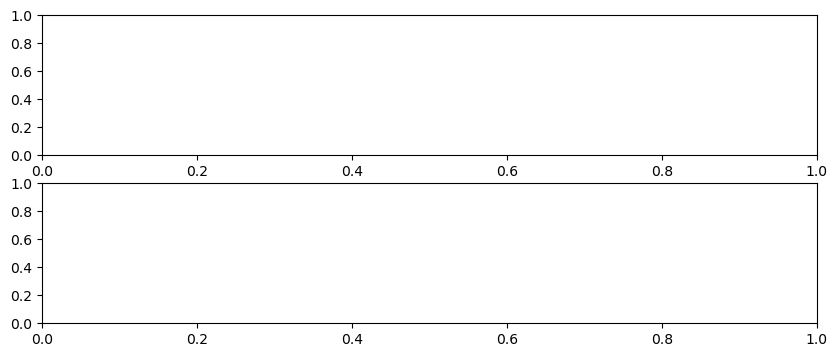

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(10, 4))

axes[0].pcolormesh(time, decoder.environments[0].bin_centers, log_likelihood.T, shading='auto')

axes[1].eventplot(
    spike_times,
    lineoffsets=1,
    linelengths=0.5,
    color="black",
)
plt.xlim((time[0], time[100]))

In [ ]:
log_likelihood.max()

In [ ]:
from non_local_detector.likelihoods.common import get_spikecount_per_time_bin

is_spike = get_spikecount_per_time_bin(spike_times=spike_times[10], time=time)
for ind in np.nonzero(is_spike)[0]:
    plt.plot(np.exp(log_likelihood[ind]), label=f"Spike {ind}")